# Qutrit Machine Learning Optimizaiton 

Author: Bora Basyildiz

## Imports

In [5]:
import torch
import numpy as np
from itertools import permutations
from itertools import product
import matplotlib.pyplot as plt
import random

# Previous Function Defintions

In [3]:
def fidelity_ml(J,B,M,target_gate,t,N_iter):
    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Mon Aug 16 4:33 2021

    @author: Bora & Alex

    This is the original code for Joel's Paper
    """
    
    #Pauli Matricies 
    sx = np.array([[0, 1], [1, 0]])
    sy = np.array([[0,-1j],[1j,0]])
    sz = np.array([[1, 0], [0, -1]])
    id = np.array([[1,0],[0,1]])
    
    #Function definitions 
    def zero_mat(N):#Generates matrix of zeros
        zero_gate = np.array([[0,0],[0,0]])
        init = np.array([[0,0],[0,0]])
        if N < 2:
            return 1
        for i in range(0,N - 1):
            zero_gate = torch.tensor(np.kron(zero_gate,init))
        return zero_gate
    def sum_pauli(coef, gate):#Sums Pauli gates with coefficients 
        N = len(coef)#number of qubits
        total_pauli = zero_mat(N)
        #Summing all Z gates
        for i in range(0,N):
            pauli_temp = 1
            for j in range(0,i):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            pauli_temp = torch.tensor(np.kron(pauli_temp,gate))
            for j in range(i+1,N):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            total_pauli = total_pauli + coef[i]*pauli_temp
        return total_pauli

    #variable initializations
    N = len(B)
    torch.manual_seed(random.randint(0,1000))
    dt = torch.cdouble # datatype and precision
    infidelity_list=torch.zeros([N_iter,1])

    #J coefficients gathering (only if J is in N x N matrix, otherwise set J_coef=J)
    J_coef = []
    for i in range(0,len(J) - 1):
        for j in range(0,len(J) - i - 1):
            J_coef.append(J[i,j].item())

    #H0 generation
    permuts = [1,1]
    for i in range(2,N):
        permuts.append(0)
    permuts = list(set(permutations(permuts,N)))
    permuts.sort()
    permuts.reverse()#All permutations of ZZ coupling stored as bit arrays
    H0 = zero_mat(N)
    for i,u in enumerate(permuts):#summing ZZ permutations and J constants
        ZZ_temp = 1
        for p in u:
            if p==1:
                ZZ_temp = torch.tensor(np.kron(ZZ_temp,sz))
            else:
                ZZ_temp = torch.tensor(np.kron(ZZ_temp,id))
        H0 = H0 + J_coef[i]*ZZ_temp

    #H0 = H0 + sum_pauli(B,sz)

    #Unitary group generation
    SU = []
    pauli_int = [1, 2, 3, 4]#eq to [sx,sy,sz,id]
    perms = list(product(pauli_int,repeat=N))#all permutations of paulis
    for p in perms:#mapping integers to pauli 
        unitary = 1
        for pauli in p:
            if pauli == 1:
                unitary = torch.tensor(np.kron(unitary,sx),dtype=torch.cdouble)
            elif pauli == 2:
                unitary = torch.tensor(np.kron(unitary,sy),dtype=torch.cdouble)
            elif pauli == 3:
                unitary = torch.tensor(np.kron(unitary,sz),dtype=torch.cdouble)
            elif pauli == 4:
                unitary = torch.tensor(np.kron(unitary,id),dtype=torch.cdouble)
        SU.append(unitary)

    #These are the coefficients we are optimizing
    R = torch.rand([M,2*N], dtype=torch.double) *2*np.pi # Random initialization (between 0 and 2pi)
    R.requires_grad = True # set flag so we can backpropagate

    #Optimizer settings(can be changed & opttimized)
    lr=0.3#learning rate

    opt = 'SGD'  # Choose optimizer - ADAM, SGD (typical). ADAMW, ADAMax, Adadelta,  
                        # Adagrad, Rprop, RMSprop, ASGD, also valid options.     
    sched = 'Plateau'  # Choose learning rate scheduler - Plateau, Exponential (typical), Step
    
    if opt=='ADAM': optimizer = torch.optim.Adam([R], lr = lr, weight_decay=1e-6)
    elif opt=='ADAMW': optimizer = torch.optim.AdamW([R], lr = lr, weight_decay=0.01)
    elif opt=='ADAMax': optimizer = torch.optim.Adamax([R], lr = lr, weight_decay=0.01)
    elif opt=='RMSprop': optimizer = torch.optim.RMSprop([R], lr = lr, momentum=0.2)
    elif opt=='Rprop': optimizer = torch.optim.Rprop([R], lr = lr)
    elif opt=='Adadelta': optimizer = torch.optim.Adadelta([R], lr = lr) 
    elif opt=='Adagrad': optimizer = torch.optim.Adagrad([R], lr = lr)
    elif opt=='SGD': optimizer = torch.optim.SGD([R], lr = lr, momentum=0.99, nesterov=True)
    elif opt=='ASGD': optimizer = torch.optim.ASGD([R], lr = lr)
    else: optimizer=None; opt='None'
        
    if sched=='Step': scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=N_iter/10, gamma=0.9)
    elif sched=='Exponential': scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    elif sched=='Plateau': scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=0.03, factor=0.3 , patience= 20 ); loss_in=True; 
    else: scheduler=None; sched='None'

    for n in range(0,N_iter):
        #Creating Hamilontian
        U_Exp = 1
        for i in range(0,N):
            U_Exp = torch.tensor(np.kron(U_Exp,id),dtype=dt)#initializing unitary
        for m in range(0,M):#Product of pulses
            pulse_coef = R[m]
            H1 = sum_pauli(pulse_coef[:N],sx) + sum_pauli(pulse_coef[N:],sy)
            U_Exp = torch.matmul(torch.matrix_exp(-1j*(H0+H1)*t/M),U_Exp)

        #Fidelity calulcation given by Nielsen Paper
        fidelity = 0
        d = 2**N
        for i in range(0,len(SU)):
            eps_U = torch.matmul(torch.matmul(U_Exp,SU[i]),(U_Exp.conj().T))
            target_U = torch.matmul(torch.matmul(target_gate,(SU[i].conj().T)),(target_gate.conj().T))
            tr = torch.trace(torch.matmul(target_U,eps_U))
            fidelity = fidelity + tr
        fidelity = abs(fidelity + d*d)/(d*d*(d+1))    
        infidelity = 1 - fidelity
        infidelity_list[n] = infidelity.detach()
        infidelity.backward()

        #Printing statement
        #if (n+1)%20==0: 
            #print('Itertation ', str(n+1), ' out of ', str(N_iter), 'complete. Avg Infidelity: ', str(infidelity.item()))

        #optimizer 
        if optimizer is not None and scheduler is None:  # Update R
            optimizer.step()
            optimizer.zero_grad()
        elif optimizer is not None and scheduler is not None:
            optimizer.step()
            if loss_in: 
                scheduler.step(infidelity)
            else: 
                scheduler.step()
            optimizer.zero_grad()
        else:
            R.data.sub_(lr*R.grad.data) # using data avoids overwriting tensor object
            R.grad.data.zero_()           # and it's respective grad info
    
    #print('The infidelity of the generated gate is: ' + str(infidelity_list.min().item()))
    #return R
    return infidelity_list.min().item()

In [9]:
def fidelity_XX(J,B,M,input_gate,t,N_iter):
    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Mon Aug 16 4:33 2021

    @author: Bora & Alex
    """
    #imports

    #Pauli Matricies 
    sx = np.array([[0, 1], [1, 0]])
    sy = np.array([[0,-1j],[1j,0]])
    sz = np.array([[1, 0], [0, -1]])
    id = np.array([[1,0],[0,1]])
    
    #Function definitions 
    def zero_mat(N):#Generates matrix of zeros
        zero_gate = np.array([[0,0],[0,0]])
        init = np.array([[0,0],[0,0]])
        if N < 2:
            return 1
        for i in range(0,N - 1):
            zero_gate = torch.tensor(np.kron(zero_gate,init))
        return zero_gate
    def sum_pauli(coef, gate):#Sums Pauli gates with coefficients 
        N = len(coef)#number of qubits
        total_pauli = zero_mat(N)
        #Summing all Z gates
        for i in range(0,N):
            pauli_temp = 1
            for j in range(0,i):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            pauli_temp = torch.tensor(np.kron(pauli_temp,gate))
            for j in range(i+1,N):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            total_pauli = total_pauli + coef[i]*pauli_temp
        return total_pauli

    #variable initializations
    N = len(B)
    torch.manual_seed(random.randint(0,1000))
    dt = torch.cdouble # datatype and precision
    infidelity_list=torch.zeros([N_iter,1])

    #J coefficients gathering (only if J is in N x N matrix, otherwise set J_coef=J)
    J_coef = []
    for i in range(0,len(J) - 1):
        for j in range(0,len(J) - i - 1):
            J_coef.append(J[i,j].item())

    #H0 generation
    permuts = [1,1]
    for i in range(2,N):
        permuts.append(0)
    permuts = list(set(permutations(permuts,N)))
    permuts.sort()
    permuts.reverse()#All permutations of ZZ coupling stored as bit arrays
    H0 = zero_mat(N)
    ##Changed gates ZZ -> XX
    for i,u in enumerate(permuts):#summing ZZ permutations and J constants
        XX_temp = 1
        for p in u:
            if p==1:
                XX_temp = torch.tensor(np.kron(XX_temp,sx))
            else:
                XX_temp = torch.tensor(np.kron(XX_temp,id))
        H0 = H0 + J_coef[i]*XX_temp

    #H0 = H0 + sum_pauli(B,sz)
    #print(H0) <- checking if the H0 is a XX gate 

    #Unitary group generation
    SU = []
    pauli_int = [1, 2, 3, 4]#eq to [sx,sy,sz,id]
    perms = list(product(pauli_int,repeat=N))#all permutations of paulis
    for p in perms:#mapping integers to pauli 
        unitary = 1
        for pauli in p:
            if pauli == 1:
                unitary = torch.tensor(np.kron(unitary,sx),dtype=torch.cdouble)
            elif pauli == 2:
                unitary = torch.tensor(np.kron(unitary,sy),dtype=torch.cdouble)
            elif pauli == 3:
                unitary = torch.tensor(np.kron(unitary,sz),dtype=torch.cdouble)
            elif pauli == 4:
                unitary = torch.tensor(np.kron(unitary,id),dtype=torch.cdouble)
        SU.append(unitary)

    #These are the coefficients we are optimizing
    R = torch.rand([M,2*N], dtype=torch.double) *2*np.pi # Random initialization (between 0 and 2pi)
    R.requires_grad = True # set flag so we can backpropagate

    #Optimizer settings(can be changed & opttimized)
    lr=0.3#learning rate

    opt = 'SGD'  # Choose optimizer - ADAM, SGD (typical). ADAMW, ADAMax, Adadelta,  
                        # Adagrad, Rprop, RMSprop, ASGD, also valid options.     
    sched = 'Plateau'  # Choose learning rate scheduler - Plateau, Exponential (typical), Step
    
    if opt=='ADAM': optimizer = torch.optim.Adam([R], lr = lr, weight_decay=1e-6)
    elif opt=='ADAMW': optimizer = torch.optim.AdamW([R], lr = lr, weight_decay=0.01)
    elif opt=='ADAMax': optimizer = torch.optim.Adamax([R], lr = lr, weight_decay=0.01)
    elif opt=='RMSprop': optimizer = torch.optim.RMSprop([R], lr = lr, momentum=0.2)
    elif opt=='Rprop': optimizer = torch.optim.Rprop([R], lr = lr)
    elif opt=='Adadelta': optimizer = torch.optim.Adadelta([R], lr = lr) 
    elif opt=='Adagrad': optimizer = torch.optim.Adagrad([R], lr = lr)
    elif opt=='SGD': optimizer = torch.optim.SGD([R], lr = lr, momentum=0.99, nesterov=True)
    elif opt=='ASGD': optimizer = torch.optim.ASGD([R], lr = lr)
    else: optimizer=None; opt='None'
        
    if sched=='Step': scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=N_iter/10, gamma=0.9)
    elif sched=='Exponential': scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    elif sched=='Plateau': scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=0.03, factor=0.3 , patience= 20 ); loss_in=True; 
    else: scheduler=None; sched='None'

    for n in range(0,N_iter):
        #Creating Hamilontian
        U_Exp = 1
        for i in range(0,N):
            U_Exp = torch.tensor(np.kron(U_Exp,id),dtype=dt)#initializing unitary
        for m in range(0,M):#Product of pulses
            pulse_coef = R[m]
            H1 = sum_pauli(pulse_coef[:N],sx) + sum_pauli(pulse_coef[N:],sy)
            U_Exp = torch.matmul(torch.matrix_exp(-1j*(H0+H1)*t/M),U_Exp)

        #Fidelity calulcation given by Nielsen Paper
        fidelity = 0
        d = 2**N
        for i in range(0,len(SU)):
            ideal_U = torch.matmul(torch.matmul(input_gate,SU[i]),(input_gate.conj().T))
            target_U = torch.matmul(torch.matmul(U_Exp,SU[i]),(U_Exp.conj().T)) # This is Eps(U) = pulse_gate * pauli * pulse_gate^H
            tr = torch.trace(torch.matmul(ideal_U,target_U))
            fidelity = fidelity + tr
        fidelity = abs(fidelity + d*d)/(d*d*(d+1))    
        infidelity = 1 - fidelity
        infidelity_list[n] = infidelity.detach()
        infidelity.backward()

        #Printing statement
        #if (n+1)%100==0: 
            #print('Itertation ', str(n+1), ' out of ', str(N_iter), 'complete. Avg Infidelity: ', str(infidelity.item()))

        #optimizer 
        if optimizer is not None and scheduler is None:  # Update R
            optimizer.step()
            optimizer.zero_grad()
        elif optimizer is not None and scheduler is not None:
            optimizer.step()
            if loss_in: 
                scheduler.step(infidelity)
            else: 
                scheduler.step()
            optimizer.zero_grad()
        else:
            R.data.sub_(lr*R.grad.data) # using data avoids overwriting tensor object
            R.grad.data.zero_()           # and it's respective grad info
    
    #print('The infidelity of the generated gate is: ' + str(infidelity_list.min().item()))
    #return R
    return infidelity_list.min().item()

# Qutrit Function Defintion

In [110]:
def fidelity_Qutrit(J,B,M,input_gate,t,N_iter):
    #!/usr/bin/env python3
    # -*- coding: utf-8 -*-
    """
    Created on Mon Aug 16 4:33 2021

    @author: Bora & Alex
    """
    #imports

    #Pauli Matricies 
    l1 = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]) 
    l2 = np.array([[0,-1j, 0],[1j,0, 0], [0, 0, 0]]) 
    l3 = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]) 
    l4 = np.array([[0,0,1],[0,0,0],[1,0,0]])
    l5 = np.array([[0,0,-1j],[0,0,0],[1j,0,0]])
    l6 = np.array([[0,0,0],[0,0,1],[0,1,0]]) #essentially X for 1->2 transition
    l7 = np.array([[0,0,0],[0,0,-1j],[0,1j,0]]) #essentially Y for 1->2 transition
    l8 = 1/np.sqrt(3) * np.array([[1,0,0],[0,1,0],[0,0,-2]])
    id = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])

    sx = np.array([[0,1,0],[1,0,0],[0,0,1]])
    sy = np.array([[0,-1j,0],[1j,0,0],[0,0,1]])
    sx2 = np.array([[1,0,0],[0,0,1],[0,1,0]])
    sy2 = np.array([[1,0,0],[0,0,-1j],[0,1j,0]])
    sx02 = np.array([[0,0,1],[0,1,0],[1,0,0]])
    sy02 = np.array([[0,0,-1j],[0,1,0],[1j,0,0]])
    sz = np.array([[1,0,0],[0,-1,0],[0,0,1]])
    
    #Function definitions 
    def zero_mat(N):#Generates matrix of zeros
        zero_gate = np.array([[0,0,0],[0,0,0],[0,0,0]])
        init = zero_gate
        if N < 2:
            return 1
        for i in range(0,N - 1):
            zero_gate = torch.tensor(np.kron(zero_gate,init),dtype=torch.cdouble)
        return zero_gate
    def sum_pauli(coef, gate):#Sums Pauli gates with coefficients 
        N = len(coef)#number of qubits
        total_pauli = zero_mat(N)
        #Summing all Z gates
        for i in range(0,N):
            pauli_temp = 1
            for j in range(0,i):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            pauli_temp = torch.tensor(np.kron(pauli_temp,gate))
            for j in range(i+1,N):
                pauli_temp = torch.tensor(np.kron(pauli_temp,id))
            total_pauli = total_pauli + coef[i]*pauli_temp
        #return torch.tensor(total_pauli,dtype=torch.cdouble)
        return total_pauli

    #variable initializations
    N = len(B)
    torch.manual_seed(1)
    dt = torch.cdouble # datatype and precision
    infidelity_list=torch.zeros([N_iter,1])

    #J coefficients gathering (only if J is in N x N matrix, otherwise set J_coef=J) <- essentially flattens the array
    J_coef = []
    for i in range(0,len(J) - 1):
        for j in range(0,len(J) - i - 1):
            J_coef.append(J[i,j].item())

    #H0 generation
    permuts = [1,1]
    for i in range(2,N):
        permuts.append(0)
    permuts = list(set(permutations(permuts,N)))
    permuts.sort()
    permuts.reverse()#All permutations of ZZ coupling stored as bit arrays
    H0 = zero_mat(N)
    ##Changed gates ZZ -> XX
    for i,u in enumerate(permuts):#summing ZZ permutations and J constants
        XX_temp = 1
        for p in u:
            if p==1:
                XX_temp = torch.tensor(np.kron(XX_temp,l1))
            else:
                XX_temp = torch.tensor(np.kron(XX_temp,id))
        H0 = H0 + J_coef[i]*XX_temp
    #H0 = H0 + sum_pauli(B,sz)

    #These are the coefficients we are optimizing
    R = torch.rand([M,4*N], dtype=torch.double) *2*np.pi # Random initialization (between 0 and 2pi)
    R.requires_grad = True # set flag so we can backpropagate

    #Optimizer settings(can be changed & opttimized)
    lr=0.3#learning rate

    opt = 'SGD'  # Choose optimizer - ADAM, SGD (typical). ADAMW, ADAMax, Adadelta,  
                        # Adagrad, Rprop, RMSprop, ASGD, also valid options.     
    sched = 'Plateau'  # Choose learning rate scheduler - Plateau, Exponential (typical), Step
    
    if opt=='ADAM': optimizer = torch.optim.Adam([R], lr = lr, weight_decay=1e-6)
    elif opt=='ADAMW': optimizer = torch.optim.AdamW([R], lr = lr, weight_decay=0.01)
    elif opt=='ADAMax': optimizer = torch.optim.Adamax([R], lr = lr, weight_decay=0.01)
    elif opt=='RMSprop': optimizer = torch.optim.RMSprop([R], lr = lr, momentum=0.2)
    elif opt=='Rprop': optimizer = torch.optim.Rprop([R], lr = lr)
    elif opt=='Adadelta': optimizer = torch.optim.Adadelta([R], lr = lr) 
    elif opt=='Adagrad': optimizer = torch.optim.Adagrad([R], lr = lr)
    elif opt=='SGD': optimizer = torch.optim.SGD([R], lr = lr, momentum=0.99, nesterov=True)
    elif opt=='ASGD': optimizer = torch.optim.ASGD([R], lr = lr)
    else: optimizer=None; opt='None'
        
    if sched=='Step': scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=N_iter/10, gamma=0.9)
    elif sched=='Exponential': scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    elif sched=='Plateau': scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=0.03, factor=0.3 , patience= 20 ); loss_in=True; 
    else: scheduler=None; sched='None'

    for n in range(0,N_iter):
        #Creating Drive Hamilontian
        U_Exp = 1
        for i in range(0,N):
            U_Exp = torch.tensor(np.kron(U_Exp,id),dtype=dt)#initializing unitary
        for m in range(0,M):#Product of pulses
            pulse_coef = R[m]
            #H1 = sum_pauli(pulse_coef[:N],l1) + sum_pauli(pulse_coef[N:2*N],l2) + sum_pauli(pulse_coef[2*N:3*N],l4) + sum_pauli(pulse_coef[3*N:4*N],l5) + sum_pauli(pulse_coef[4*N:5*N],l6) + sum_pauli(pulse_coef[5*N:],l7) 
            H1 = sum_pauli(pulse_coef[:N],l1) + sum_pauli(pulse_coef[N:2*N],l2) + sum_pauli(pulse_coef[2*N:3*N],l4) 
            #H1 = sum_pauli(pulse_coef[:N],l1) + sum_pauli(pulse_coef[N:2*N],l2) 
            U_Exp = torch.matmul(torch.matrix_exp(-1j*(H0+H1)*t/M),U_Exp)
        
        #Orthonormal Matrix Generation 
        def Matrix_Basis_Gen(d):
            X = np.zeros([d,d])
            for i in range(d):
                X[(i+1) % d,i] = 1
            Z = np.zeros([d,d],dtype=np.complex_)
            for i in range(d):
                Z[i,i] = np.exp((2*np.pi * 1j * i)/d)
            Basis = []
            for i in range(d):
                for j in range(d):
                    Basis.append(torch.tensor(np.matmul(np.linalg.matrix_power(X,i),np.linalg.matrix_power(Z,j)),dtype=torch.cdouble))
            return Basis

        #Fidelity calulcation given by Nielsen Paper
        fidelity = 0
        d = 3**N
        
        for U in Matrix_Basis_Gen(d):
            ideal_U = torch.matmul(torch.matmul(input_gate,U.conj().T),(input_gate.conj().T))
            target_U = torch.matmul(torch.matmul(U_Exp,U),(U_Exp.conj().T)) # This is Eps(U) = pulse_gate * pauli * pulse_gate^H
            tr = torch.trace(torch.matmul(ideal_U,target_U))
            fidelity = fidelity + tr 
        fidelity = abs(fidelity + d**2)/(d**2 *(d+1))    
        infidelity = 1 - fidelity
        infidelity_list[n] = infidelity.detach()
        infidelity.backward()

        #Printing statement
        if (n+1)%50==0: 
            print('Itertation ', str(n+1), ' out of ', str(N_iter), 'complete. Avg Infidelity: ', str(infidelity.item()))

        #optimizer 
        if optimizer is not None and scheduler is None:  # Update R
            optimizer.step()
            optimizer.zero_grad()
        elif optimizer is not None and scheduler is not None:
            optimizer.step()
            if loss_in: 
                scheduler.step(infidelity)
            else: 
                scheduler.step()
            optimizer.zero_grad()
        else:
            R.data.sub_(lr*R.grad.data) # using data avoids overwriting tensor object
            R.grad.data.zero_()           # and it's respective grad info
    
    #print('The infidelity of the generated gate is: ' + str(infidelity_list.min().item()))
    return R
    #return infidelity_list.min().item()

# Non-Qutrit Testing

Text(0.5, 1.0, '2 Qubit CNOT Fidelity for ZZ coupled H0')

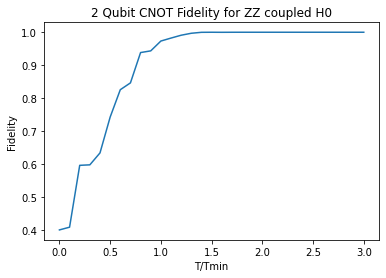

In [6]:
#graph generation for ZZ coupled Hamiltonain
CNOT = torch.tensor([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])

Fidelities = []
Times = []
for i in range(0,31):
    Times.append(i/10)
    best_fidelity = 0
    for j in range(0,10):
        temp_fidelity = 1 - fidelity_ml(J,[1,1],16,CNOT,i/10*np.pi/4,1000)
        if temp_fidelity > best_fidelity:
            best_fidelity = temp_fidelity
    Fidelities.append(best_fidelity)

plt.plot(Times,Fidelities)
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("2 Qubit CNOT Fidelity for ZZ coupled H0")

In [10]:
#graph generation for ZZ coupled Hamiltonain
CNOT = torch.tensor([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])

Fidelities = []
Times = []
for i in range(0,31):
    Times.append(i/10)
    best_fidelity = 0
    for j in range(0,10):
        temp_fidelity = 1 - fidelity_XX(J,[1,1],16,CNOT,i/10*np.pi/4,1000)
        if temp_fidelity > best_fidelity:
            best_fidelity = temp_fidelity
    Fidelities.append(best_fidelity)

plt.plot(Times,Fidelities)
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("2 Qubit CNOT Fidelity for XX coupled H0")

KeyboardInterrupt: 

In [ ]:
#graph generation for XX coupled Hamiltonain
CNOT_qutrit = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])

Fidelities = []
Times = []
for i in range(0,31):
    Times.append(i/10)
    Fidelities.append(1 - fidelity_XX(J,[1,1],16,CNOT,i/10*np.pi/4,1000))

plt.plot(Times,Fidelities)
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("2 Qubit CNOT Fidelity for XX coupled H0")

In [ ]:
CNOT_qutrit = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])
fidelity_Qutrit(J,[1,1],32,CNOT_qutrit,10*np.pi,200)

Fidelities = []
Times = []
for i in range(0,31):
    Times.append(i/10)
    Fidelities.append(1 - fidelity_Qutrit(J,[1,1],16,CNOT_qutrit,i/10*np.pi/4,500))

plt.plot(Times,Fidelities)
plt.xlabel("T/Tmin")
plt.ylabel("Fidelity")
plt.title("2 Qubit CNOT Fidelity for XX coupled Qutrit H0")

In [9]:
Identity = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])
fidelity_Qutrit(J,[1,1],32,Identity,np.pi/4,1000)

Itertation  20  out of  1000 complete. Avg Infidelity:  0.8833275397898315
Itertation  40  out of  1000 complete. Avg Infidelity:  0.8830224065577897
Itertation  60  out of  1000 complete. Avg Infidelity:  0.8825532105317029
Itertation  80  out of  1000 complete. Avg Infidelity:  0.881943204055911
Itertation  100  out of  1000 complete. Avg Infidelity:  0.8812154639972397
Itertation  120  out of  1000 complete. Avg Infidelity:  0.8803944323145223
Itertation  140  out of  1000 complete. Avg Infidelity:  0.8795035617404974
Itertation  160  out of  1000 complete. Avg Infidelity:  0.8785588480811006
Itertation  180  out of  1000 complete. Avg Infidelity:  0.8775600290546578


KeyboardInterrupt: 

In [ ]:
CNOT_qutrit.T * CNOT_qutrit

tensor([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]],
       dtype=torch.complex128)

In [ ]:
CNOT_qutrit = torch.tensor([[1,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0],[0,0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0,0],
[0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,1]],dtype=torch.cdouble)
J = torch.tensor([[1,1],[1,1]])
fidelity_Qutrit(J,[1,1],32,CNOT_qutrit,10*np.pi,200)

Itertation  20  out of  200 complete. Avg Infidelity:  0.8118579802397738
Itertation  40  out of  200 complete. Avg Infidelity:  0.8082186603551773
Itertation  60  out of  200 complete. Avg Infidelity:  0.8074939484808253
Itertation  80  out of  200 complete. Avg Infidelity:  0.8073040874940538
Itertation  100  out of  200 complete. Avg Infidelity:  0.8072776392452026
Itertation  120  out of  200 complete. Avg Infidelity:  0.8072856978763698
Itertation  140  out of  200 complete. Avg Infidelity:  0.807271588421193
Itertation  160  out of  200 complete. Avg Infidelity:  0.80727785596674
Itertation  180  out of  200 complete. Avg Infidelity:  0.807272408124901
Itertation  200  out of  200 complete. Avg Infidelity:  0.8072729670784975


tensor([[ 1.4276,  5.5662,  2.2977,  0.6540],
        [-0.0849,  4.1260,  0.7485,  0.9280],
        [ 0.8269,  3.8214,  3.1729,  1.6616],
        [ 3.5604,  2.8295,  4.8471,  0.4763],
        [ 0.4893,  5.0739,  6.0796,  3.4469],
        [ 3.7098,  0.9607,  2.3485,  4.2243],
        [ 1.1343,  0.3738,  5.1079,  2.8282],
        [ 0.7442,  2.5203,  1.6716,  6.3206],
        [ 1.7282,  6.0637,  5.5998,  4.6028],
        [-0.2751,  5.9062,  2.6022,  2.0082],
        [ 2.1163,  2.2922,  5.6663, -0.3232],
        [ 4.1946,  4.5616,  2.1886,  5.3798],
        [ 5.4878,  5.1738,  1.9315,  4.9067],
        [ 3.3785,  4.4344,  6.9167,  1.7313],
        [ 1.6522,  0.2232,  0.3475,  5.7342],
        [ 1.3610,  5.8410,  4.2447,  2.0582],
        [ 4.1184,  5.3460,  1.3447,  5.4545],
        [ 0.6373,  3.5061,  0.9662,  3.8482],
        [ 5.1487,  4.1360,  4.6240,  0.9626],
        [ 4.9523,  5.1393,  2.4269,  4.4603],
        [ 4.7738,  1.0045,  4.8024,  1.3207],
        [ 2.8337,  1.3251,  2.2948

We want a matrix basis that is orthonormal AND unitary. While the Gell-Mann matrices are orthonormal, they are not unitary. 

Also, we will apply a phase of i on specific matrices so that we span the complex plane 

Now we will generate these matrices through the method outlined by the Nielsen paper 

In [52]:
def X_Gen(d):
    X = np.zeros([d,d])
    for i in range(d):
        X[(i+1) % d,i] = 1
    return X

In [53]:
def Z_Gen(d):
    Z = np.zeros([d,d],dtype=np.complex_)
    for i in range(d):
        Z[i,i] = np.exp((2*np.pi * 1j * i)/d)
    return Z

In [69]:
def Matrix_Basis_Gen(d):
    X = np.zeros([d,d])
    for i in range(d):
        X[(i+1) % d,i] = 1
    Z = np.zeros([d,d],dtype=np.complex_)
    for i in range(d):
        Z[i,i] = np.exp((2*np.pi * 1j * i)/d)
    Basis = []
    for i in range(d):
        for j in range(d):
            Basis.append(np.matmul(np.linalg.matrix_power(X,i),np.linalg.matrix_power(Z,j)))
    return Basis

In [71]:
Matrix_Basis_Gen(2)

[array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]),
 array([[ 1.+0.0000000e+00j,  0.+0.0000000e+00j],
        [ 0.+0.0000000e+00j, -1.+1.2246468e-16j]]),
 array([[0.+0.j, 1.+0.j],
        [1.+0.j, 0.+0.j]]),
 array([[ 0.+0.0000000e+00j, -1.+1.2246468e-16j],
        [ 1.+0.0000000e+00j,  0.+0.0000000e+00j]])]